In [95]:
## load the libraries 
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D, Flatten, Dropout, concatenate,GlobalAveragePooling2D, AveragePooling2D, ZeroPadding2D, add, Add, LeakyReLU, ReLU, Layer
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.utils import to_categorical
from keras.models import Model
from keras.initializers import glorot_uniform, Constant
from keras import optimizers
from keras.layers.core import Activation
from keras.optimizers import Optimizer
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from numpy import argmax, array_equal
from random import randint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("data/fashion/fashion-mnist_train.csv")
test = pd.read_csv("data/fashion/fashion-mnist_test.csv")

In [3]:
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values
test_x = test[list(test.columns)[1:]].values
test_y = test['label'].values

In [4]:
train_x=train_x.reshape(60000,28,28,1)
test_x=test_x.reshape(10000,28,28,1)

In [5]:
train_y = to_categorical(train_y, num_classes = 10)
test_y = to_categorical(test_y, num_classes = 10)

In [6]:
train_x = train_x / 255
test_x = test_x / 255

In [7]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1)

In [8]:
def main_block(x, filters, n, strides, activation, initializer, dropout):
    # Normal part
    x_res = Conv2D(filters, (3,3), strides=strides, padding="same", kernel_initializer=initializer, kernel_regularizer=l2(5e-4))(x)
    x_res = BatchNormalization()(x_res)
    x_res = activation()(x_res)
    x_res = Conv2D(filters, (3,3), padding="same", kernel_initializer=initializer)(x_res)
    # Alternative branch
    x = Conv2D(filters, (1,1), strides=strides)(x)
    # Merge Branches
    x = Add()([x_res, x])

    for i in range(n-1):
        # Residual conection
        x_res = BatchNormalization()(x)
        x_res = activation()(x_res)
        x_res = Conv2D(filters, (3,3), padding="same", kernel_initializer=initializer)(x_res)
        # Apply dropout if given
        if dropout: x_res = Dropout(rate=dropout)(x)
        # Second part
        x_res = BatchNormalization()(x_res)
        x_res = activation()(x_res)
        x_res = Conv2D(filters, (3,3), padding="same", kernel_initializer=initializer)(x_res)
        # Merge branches
        x = Add()([x, x_res])

    # Inter block part
    x = BatchNormalization()(x)
    x = activation()(x)
    return x

def build_model(input_dims, output_dim, n, k, activation, initializer, dropout=None):
    assert (n-4)%6 == 0
    assert k%2 == 0
    n = (n-4)//6 
    
    #1)Input
    inputs = Input(shape=(input_dims))

    #2)Initial part
    x = Conv2D(16, (3,3), padding="same", kernel_initializer=initializer)(inputs)
    x = BatchNormalization()(x)
    x = activation()(x)

    #3)wide blocks (can be made into for loop)
    x = main_block(x, 16*k, n, (1,1), activation, initializer, dropout)
    x = main_block(x, 32*k, n, (2,2), activation, initializer, dropout)
    x = main_block(x, 64*k, n, (2,2), activation, initializer, dropout)

    #4)Final part
    x = AveragePooling2D((7,7))(x)
    x = Flatten()(x)
    outputs = Dense(output_dim, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [9]:
best_model = build_model((28,28,1), 10, 40, 4, ReLU, 'he_uniform',  0.1498182282337851)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
best_model.load_weights("best-augmented-model.hdf5")

In [11]:
y_pred = best_model.predict(test_x)
accuracy_score(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1))

0.9524

In [14]:
matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))

In [15]:
matrix

array([[879,   1,  18,  11,   1,   0,  88,   0,   2,   0],
       [  0, 997,   0,   3,   0,   0,   0,   0,   0,   0],
       [ 10,   0, 925,  10,  24,   0,  30,   0,   1,   0],
       [  5,   4,   0, 969,   9,   0,  12,   0,   1,   0],
       [  0,   0,  15,  17, 938,   0,  30,   0,   0,   0],
       [  0,   0,   0,   0,   0, 990,   0,   9,   0,   1],
       [ 49,   0,  29,  21,  28,   0, 870,   0,   3,   0],
       [  0,   0,   0,   0,   0,   3,   0, 974,   0,  23],
       [  0,   0,   0,   0,   1,   0,   1,   0, 998,   0],
       [  0,   0,   0,   0,   0,   2,   0,  14,   0, 984]], dtype=int64)

In [45]:
wrong_shirts_x=test_x[((np.argmax(test_y, axis=1) != np.argmax(y_pred, axis=1)) & (np.argmax(y_pred, axis=1) == 6))]
wrong_shirts_y=test_y[((np.argmax(test_y, axis=1) != np.argmax(y_pred, axis=1)) & (np.argmax(y_pred, axis=1) == 6))]

In [62]:
labels=np.array(["T-shirt", "Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"])

In [85]:
wrong_shirts_label=np.empty(wrong_shirts_y.shape[0], dtype='object')
for i, row in enumerate(wrong_shirts_y):
    wrong_shirts_label[i]=labels[[x==1 for x in row]][0]

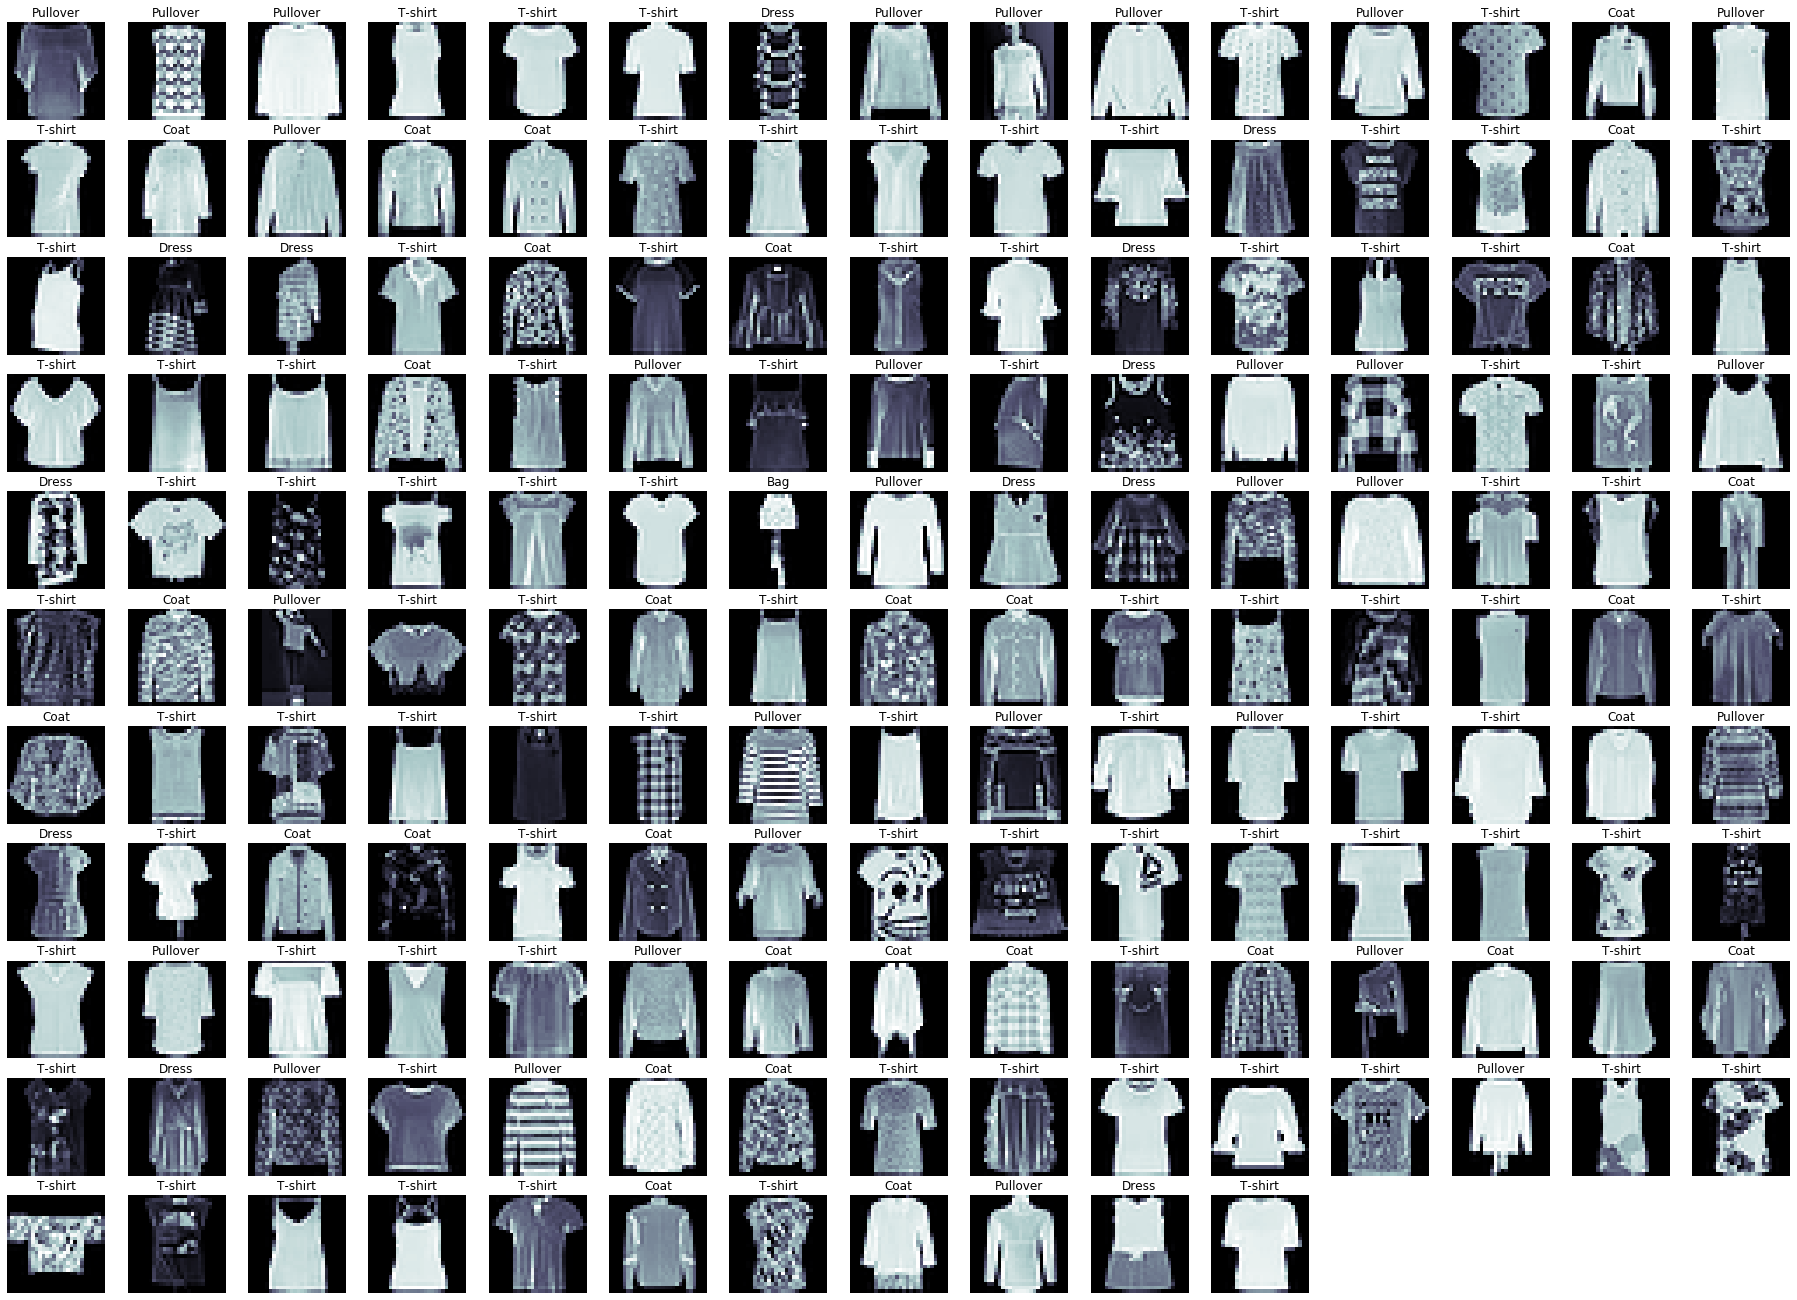

In [87]:
plt.figure(figsize=(32, 32))
for i, row in enumerate(wrong_shirts_x):
    plt.subplot(15, 15, i+1)
    plt.imshow(row.reshape(28,28),cmap='bone')
    plt.title(wrong_shirts_label[i])
    plt.axis('off')

In [ ]:
def main_block(x, filters, n, strides, activation, initializer, dropout):
    # Normal part
    x_res = Conv2D(filters, (3,3), strides=strides, padding="same", kernel_initializer=initializer, kernel_regularizer=l2(5e-4))(x)
    x_res = BatchNormalization()(x_res)
    x_res = activation()(x_res)
    x_res = Conv2D(filters, (3,3), padding="same", kernel_initializer=initializer)(x_res)
    # Alternative branch
    x = Conv2D(filters, (1,1), strides=strides)(x)
    # Merge Branches
    x = Add()([x_res, x])

    for i in range(n-1):
        # Residual conection
        x_res = BatchNormalization()(x)
        x_res = activation()(x_res)
        x_res = Conv2D(filters, (3,3), padding="same", kernel_initializer=initializer)(x_res)
        # Apply dropout if given
        if dropout: x_res = Dropout(rate=dropout)(x)
        # Second part
        x_res = BatchNormalization()(x_res)
        x_res = activation()(x_res)
        x_res = Conv2D(filters, (3,3), padding="same", kernel_initializer=initializer)(x_res)
        # Merge branches
        x = Add()([x, x_res])

    # Inter block part
    x = BatchNormalization()(x)
    x = activation()(x)
    return x

def build_model(input_dims, output_dim, n, k, activation, initializer, dropout=None):
    assert (n-4)%6 == 0
    assert k%2 == 0
    n = (n-4)//6 
    
    #1)Input
    inputs = Input(shape=(input_dims))

    #2)Initial part
    x = Conv2D(16, (3,3), padding="same", kernel_initializer=initializer)(inputs)
    x = BatchNormalization()(x)
    x = activation()(x)

    #3)wide blocks (can be made into for loop)
    x = main_block(x, 16*k, n, (1,1), activation, initializer, dropout)
    x = main_block(x, 32*k, n, (2,2), activation, initializer, dropout)
    x = main_block(x, 64*k, n, (2,2), activation, initializer, dropout)

    #4)Final part
    x = AveragePooling2D((7,7))(x)
    x = Flatten()(x)
    outputs = Dense(output_dim, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [92]:
class Swish(Layer):
    def __init__(self, beta=1, **kwargs):
        super(Swish, self).__init__(**kwargs)
        self.beta = K.cast_to_floatx(beta)

    def call(self, inputs):
        return K.sigmoid(self.beta * inputs) * inputs

    def get_config(self):
        config = {'beta': float(self.beta)}
        base_config = super(Swish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [93]:
def main_block(x, filters, n, strides, activation, initializer, dropout):
    x_res = Conv2D(filters, (3,3), strides=strides, padding="same", kernel_initializer=initializer, kernel_regularizer=l2(5e-4))(x)
    x_res = BatchNormalization()(x_res)
    x_res = activation()(x_res)
    x_res = Conv2D(filters, (3,3), padding="same", kernel_initializer=initializer)(x_res)
    x = Conv2D(filters, (1,1), strides=strides)(x)
    x = Add()([x_res, x])

    for i in range(n-1):
        x_res = BatchNormalization()(x)
        x_res = activation()(x_res)
        x_res = Conv2D(filters, (3,3), padding="same", kernel_initializer=initializer)(x_res)
        if dropout: x_res = Dropout(rate=dropout)(x)
        x_res = BatchNormalization()(x_res)
        x_res = activation()(x_res)
        x_res = Conv2D(filters, (3,3), padding="same", kernel_initializer=initializer)(x_res)
        x = Add()([x, x_res])

    x = BatchNormalization()(x)
    x = activation()(x)
    return x

def build_model(input_dims, output_dim, n, k, activation, initializer, dropout=None):
    assert (n-4)%6 == 0
    assert k%2 == 0
    n = (n-4)//6 
    
    inputs = Input(shape=(input_dims))

    x = Conv2D(16, (3,3), padding="same", kernel_initializer=initializer)(inputs)
    x = BatchNormalization()(x)
    x = activation()(x)

    x = main_block(x, 32*k, n, (1,1), activation, initializer, dropout)
    x = main_block(x, 48*k, n, (2,2), activation, initializer, dropout)
    x = main_block(x, 64*k, n, (2,2), activation, initializer, dropout)

    x = AveragePooling2D((7,7))(x)
    x = Flatten()(x)
    outputs = Dense(output_dim, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [96]:
best_model = build_model((28,28,1), 10, 40, 4, Swish, 'he_uniform',  0.1498182282337851)

In [97]:
best_model.load_weights("current-sota-model2.hdf5")

In [98]:
y_pred = best_model.predict(test_x)
accuracy_score(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1))

0.9471

In [99]:
matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))

In [100]:
matrix

array([[894,   0,  24,   5,   1,   0,  67,   0,   9,   0],
       [  1, 994,   0,   2,   0,   0,   1,   0,   2,   0],
       [  9,   0, 932,   7,  16,   1,  32,   0,   3,   0],
       [ 10,   3,   3, 963,   7,   0,  13,   0,   1,   0],
       [  1,   0,  25,  19, 908,   0,  42,   0,   5,   0],
       [  0,   0,   0,   0,   0, 988,   0,  11,   0,   1],
       [ 82,   0,  35,  19,  19,   1, 838,   0,   6,   0],
       [  0,   0,   0,   0,   0,   2,   0, 974,   0,  24],
       [  0,   0,   1,   0,   0,   0,   1,   0, 998,   0],
       [  0,   0,   0,   0,   0,   2,   0,  16,   0, 982]], dtype=int64)

In [101]:
wrong_shirts_label=np.empty(wrong_shirts_y.shape[0], dtype='object')
for i, row in enumerate(wrong_shirts_y):
    wrong_shirts_label[i]=labels[[x==1 for x in row]][0]

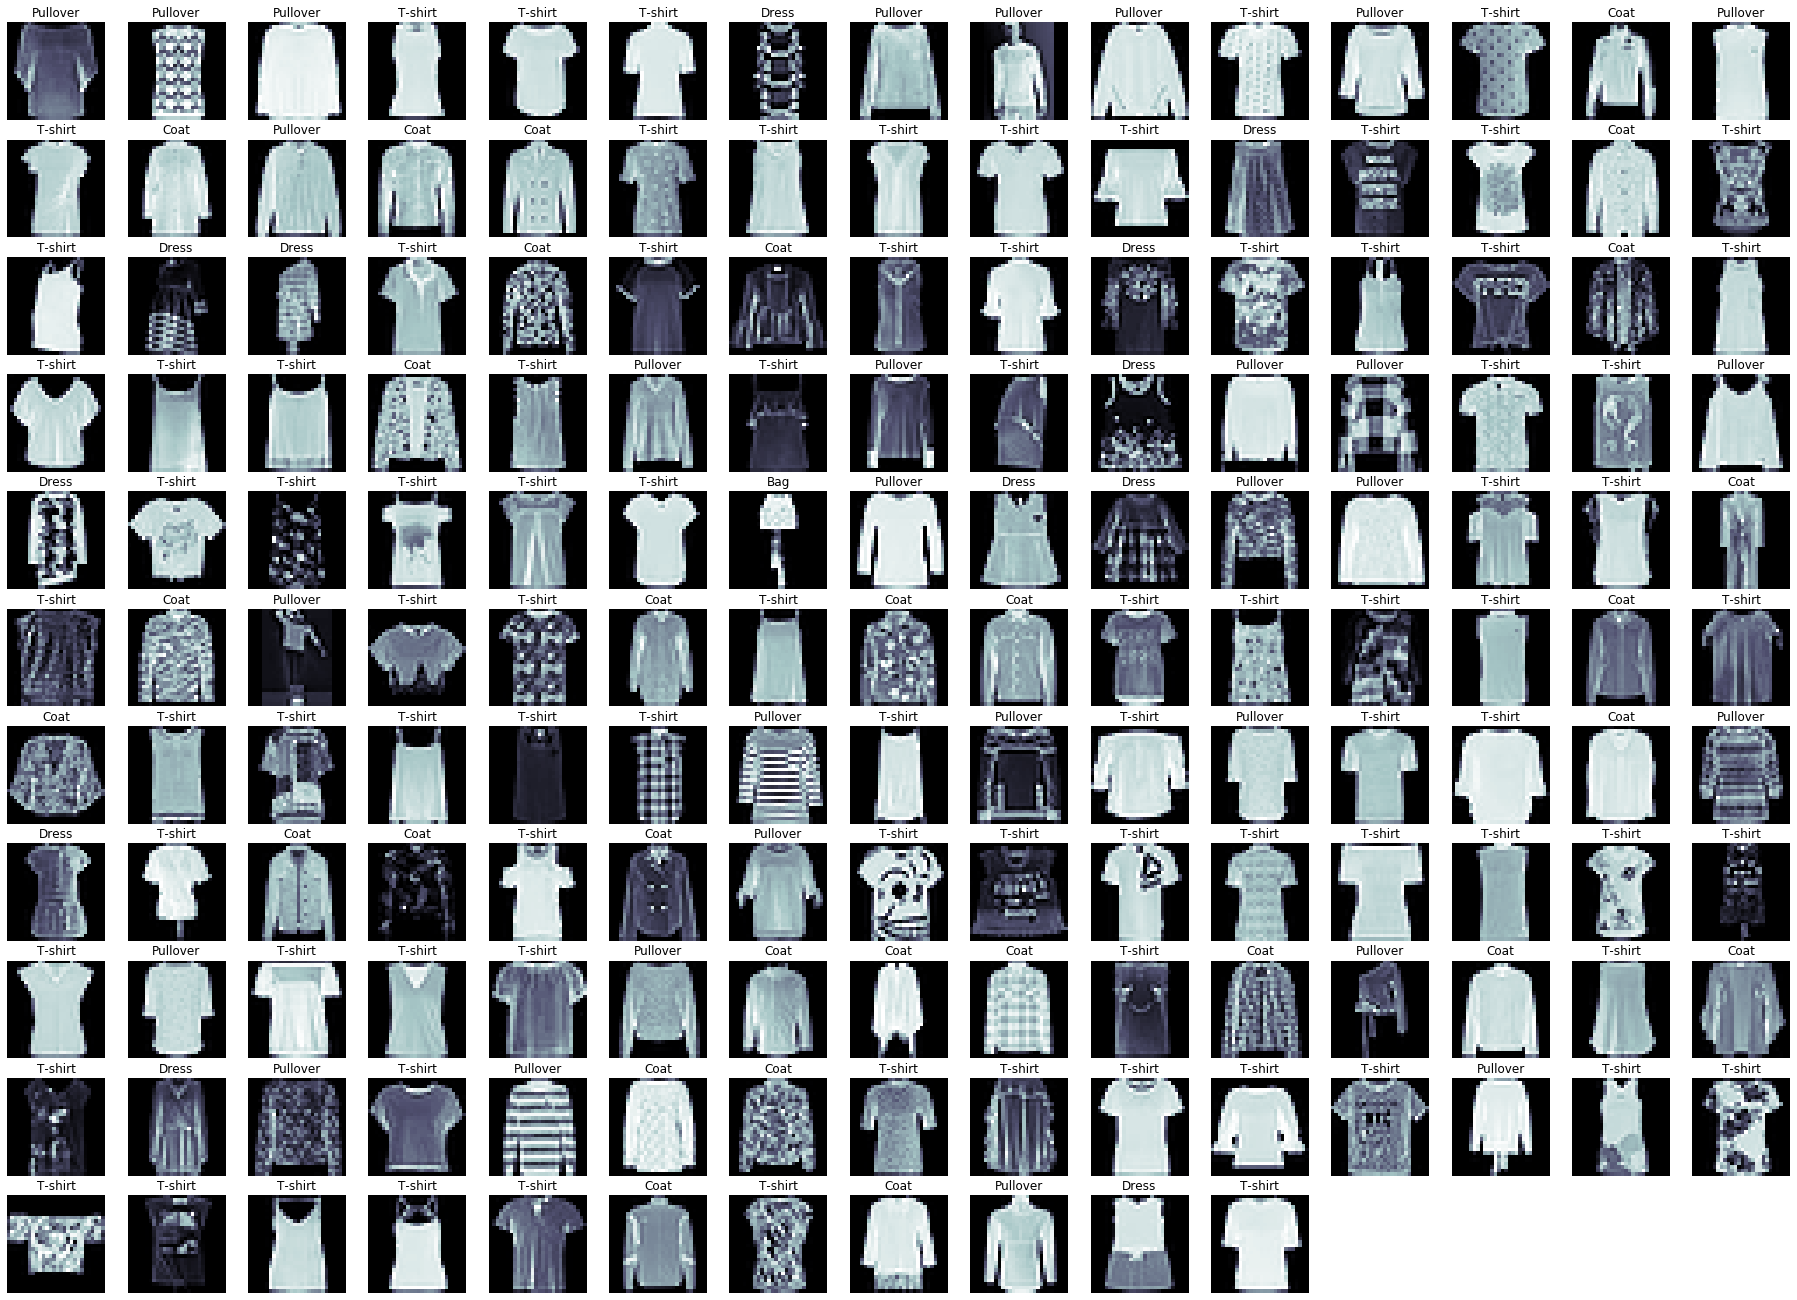

In [102]:
plt.figure(figsize=(32, 32))
for i, row in enumerate(wrong_shirts_x):
    plt.subplot(15, 15, i+1)
    plt.imshow(row.reshape(28,28),cmap='bone')
    plt.title(wrong_shirts_label[i])
    plt.axis('off')